In [ ]:
!pip install stable-baselines3 gym numpy matplotlib shimmy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

# NEW

In [ ]:
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

class BatteryEnv(gym.Env):
    def __init__(self):
        super(BatteryEnv, self).__init__()
        self.observation_space = gym.spaces.Box(
            low=np.array([0, 0, 20, 0, 0]),   # 最低值
            high=np.array([100, 5000, 30, 100, 1]),  # 最高值
            dtype=np.float32
        )
        self.action_space = gym.spaces.Discrete(3)  # 減少/維持/增加充電功率

    def reset(self):
        self.state = np.array([100, 1000, 24.0, 10, 0])  # 初始狀態
        return self.state

    def step(self, action):
        battery_charge, runtime, voltage, load, status = self.state
        if action == 0:
            battery_charge -= 1  # 減少充電功率
        elif action == 1:
            pass  # 維持
        else:
            battery_charge += 1  # 增加充電功率

        # 假設充電影響電壓和運行時間
        voltage = 24.0 + (battery_charge - 50) * 0.05
        runtime = 1000 + (battery_charge - 50) * 20

        # 獎勵函數
        reward = -abs(1000 - runtime) - abs(24 - voltage)

        done = False
        self.state = np.array([battery_charge, runtime, voltage, load, status])
        return self.state, reward, done, {}

env = DummyVecEnv([lambda: BatteryEnv()])
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)

# 測試
obs = env.reset()
for _ in range(100):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)


/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1182 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 801           |
|    iterations           | 2             |
|    time_elapsed         | 5             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00016275945 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 6.2e+07       |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00027      |
|    value_loss           | 1.3e+08       |
-------------------------

In [ ]:
import pandas as pd

obs = env.reset()
done = False

df = pd.DataFrame(columns=['state', 'reward'])

while not done:
    action, _ = model.predict(obs)  # PPO 預測最佳充電動作
    obs, reward, done, _ = env.step(action)
    print(f"狀態：{obs}, 獎勵：{reward}")
    new_row = pd.DataFrame([{'state': obs, 'reward': reward}])
    df = pd.concat([df, new_row], ignore_index=True)


串流輸出內容已截斷至最後 5000 行。
狀態：[[3.1890e+03 6.3780e+04 1.8095e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62936.95]
狀態：[[3.1890e+03 6.3780e+04 1.8095e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62936.95]
狀態：[[3.188e+03 6.376e+04 1.809e+02 1.000e+01 0.000e+00]], 獎勵：[-62916.9]
狀態：[[3.188e+03 6.376e+04 1.809e+02 1.000e+01 0.000e+00]], 獎勵：[-62916.9]
狀態：[[3.188e+03 6.376e+04 1.809e+02 1.000e+01 0.000e+00]], 獎勵：[-62916.9]
狀態：[[3.1870e+03 6.3740e+04 1.8085e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62896.85]
狀態：[[3.1870e+03 6.3740e+04 1.8085e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62896.85]
狀態：[[3.1870e+03 6.3740e+04 1.8085e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62896.85]
狀態：[[3.188e+03 6.376e+04 1.809e+02 1.000e+01 0.000e+00]], 獎勵：[-62916.9]
狀態：[[3.1870e+03 6.3740e+04 1.8085e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62896.85]
狀態：[[3.1870e+03 6.3740e+04 1.8085e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62896.85]
狀態：[[3.1870e+03 6.3740e+04 1.8085e+02 1.0000e+01 0.0000e+00]], 獎勵：[-62896.85]
狀態：[[3.188e+03 6.376e+04 1.809e+02 1.000e+01 0.000e+00]], 獎勵：[-6291

KeyboardInterrupt: 

In [ ]:
df

,state,reward
0,"[22.5, 25.25, 100.0]",19.975
1,"[25.0, 25.5, 100.0]",22.450
2,"[27.5, 25.75, 100.0]",24.925
3,"[30.0, 26.0, 100.0]",27.400
4,"[32.5, 26.25, 100.0]",29.875
5,"[35.0, 26.5, 100.0]",32.350
6,"[37.5, 26.75, 100.0]",34.825
7,"[40.0, 27.0, 100.0]",37.300
8,"[42.5, 27.25, 100.0]",39.775
9,"[45.0, 27.5, 100.0]",42.250


In [ ]:
highest_score = df.loc[df['reward'] == df['reward'].max()]
highest_score['state']
# type(highest_score['state'])

,state
30,"[100.0, 33.0, 100.0]"


*   Input_voltage 輸入電壓
*   Battery_voltage 電池電壓
*   Battery_normal_voltage 電池正常電壓 定值為24
*   Battery_capacity 目前電池電量
*   Load_level 負載率





PPO + Cosine_Similarity

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import cosine

# PPO 策略網路
class PPOPolicy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPOPolicy, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action_probs = self.softmax(self.fc3(x))
        return action_probs

# 初始化 PPO 模型
state_dim = 5  # 5 個狀態變數
action_dim = 2  # 充電 (1) / 不充電 (0)
policy = PPOPolicy(state_dim, action_dim)
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# 設定理想狀態 (S_ideal)
S_ideal = np.array([112, 24.0, 24.0, 80, 50])  # 理想狀態

# 當前電池狀態 (S_current) - 假設 UPS 輸入 210V，電池電壓 23.5V，電池容量 50%，負載 40%
S_current = np.array([112, 13.5, 24.0, 80, 100])

# 轉換成 PyTorch Tensor
S_current_tensor = torch.tensor(S_current, dtype=torch.float32)

# 使用 PPO 選擇充電策略
action_probs = policy(S_current_tensor)
action = torch.argmax(action_probs).item()  # 選擇機率最高的動作

# PPO 選擇的充電模式
charging_modes = {0: "不充電", 1: "充電"}
chosen_action = charging_modes[action]
print(f"PPO 選擇的充電策略: {chosen_action}")

# 更新 S_PPO 狀態（模擬 PPO 選擇後的影響）
if action == 1:  # 充電
    S_PPO = np.array([112, 23.8, 24.0, 70, 40])  # 充電後電壓上升，電池容量增加
else:  # 不充電
    S_PPO = S_current  # 保持原狀

# 計算餘弦相似度
cosine_similarity = 1 - cosine(S_PPO, S_ideal)
print(f"餘弦相似度: {cosine_similarity:.4f}")

# 判斷 PPO 是否選擇了理想狀態
if cosine_similarity > 0.95:
    print("PPO 選擇的策略接近理想狀態")
    print(action)
    print(S_PPO)
else:
    print("PPO 可能需要調整")
    print(not(action))

PPO 選擇的充電策略: 充電
餘弦相似度: 0.9969
PPO 選擇的策略接近理想狀態
1


# Final

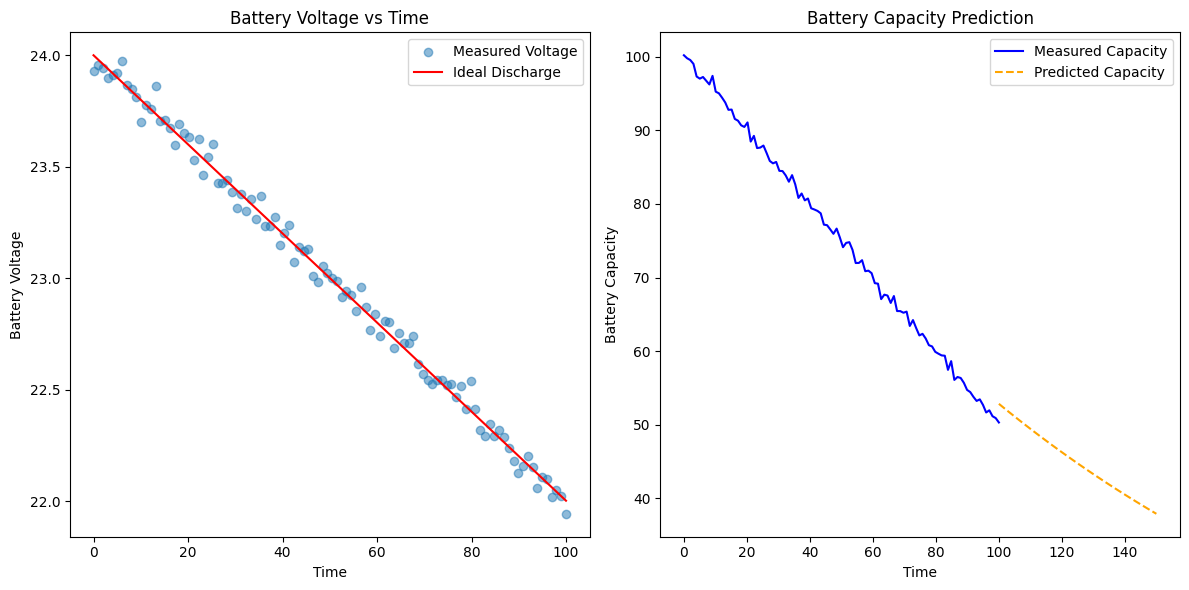

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# battery_history_data_simulation
np.random.seed(42)
time = np.linspace(0, 100, 100)
input_voltage = np.full_like(time, 14.0) + np.random.normal(110, 0.1, size=time.shape)  # input_voltage
battery_voltage = 24.0 - 0.02 * time + np.random.normal(0, 0.05, size=time.shape)  # battery_voltage
battery_capacity = 100 - 0.5 * time + np.random.normal(0, 0.5, size=time.shape)  # battery_capacity
load_level = np.full_like(time, 10.0) + np.random.normal(0, 1, size=time.shape)  # load_level

data = pd.DataFrame({
    "Time": time,
    "Input Voltage": input_voltage,
    "Battery Voltage": battery_voltage,
    "Battery Capacity": battery_capacity,
    "Load Level": load_level
})

# Define_the_ideal_battery_discharge_curve (assuming linear decay)
def discharge_curve(t, V_nom, k):
    return V_nom - k * t

# simulate_the_ideal_discharge_curve
params, _ = curve_fit(discharge_curve, data["Time"], data["Battery Voltage"])
V_nom_fit, k_fit = params

# 計算 SOH（電池健康狀態）
def calculate_soh(current_capacity, initial_capacity=100):
    return (current_capacity / initial_capacity) * 100

data["SOH"] = calculate_soh(data["Battery Capacity"])

# Exponential_decay_model_to_predict_future_capacity
def exp_decay(t, C0, lambda_):
    return C0 * np.exp(-lambda_ * t)

# 擬合指數衰減曲線
exp_params, _ = curve_fit(exp_decay, data["Time"], data["Battery Capacity"], p0=(100, 0.01))
C0_fit, lambda_fit = exp_params

# pridict_50_point_of_time
time_future = np.linspace(100, 150, 50)
predicted_capacity = exp_decay(time_future, C0_fit, lambda_fit)

# 繪圖
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data["Time"], data["Battery Voltage"], label="Measured Voltage", alpha=0.5)
plt.plot(data["Time"], discharge_curve(data["Time"], V_nom_fit, k_fit), label="Ideal Discharge", color='red')
plt.xlabel("Time")
plt.ylabel("Battery Voltage")
plt.legend()
plt.title("Battery Voltage vs Time")

plt.subplot(1, 2, 2)
plt.plot(data["Time"], data["Battery Capacity"], label="Measured Capacity", color='blue')
plt.plot(time_future, predicted_capacity, label="Predicted Capacity", linestyle='dashed', color='orange')
plt.xlabel("Time")
plt.ylabel("Battery Capacity")
plt.title("Battery Capacity Prediction")
plt.legend()

plt.tight_layout()
plt.show()

In [2]:
import numpy as np
from scipy.spatial.distance import cdist
#當下電池狀態
S_current = np.array([112, 13.5, 100, 10, 13.5 / 24.0 * 100]).reshape(1, -1)
relevant_data = data[["Input Voltage", "Battery Voltage", "Battery Capacity", "Load Level", "SOH"]].values

cosine_similarity = 1 - cdist(S_current, relevant_data, metric='cosine')
B_idea_index = np.argmax(cosine_similarity)
print(B_idea_index)
relevant_data[B_idea_index]

26


array([123.88490064,  23.42522066,  86.90082688,  11.15811087,
        86.90082688])

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import cosine

# PPO 策略網路
class PPOPolicy(nn.Module):
    def __init__(self, state_dim, action_dim):
      super(PPOPolicy, self).__init__()
      self.fc1 = nn.Linear(state_dim, 64)
      self.fc2 = nn.Linear(64, 32)
      self.fc3 = nn.Linear(32, action_dim)
      self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action_probs = self.softmax(self.fc3(x))
        return action_probs

# 初始化 PPO 模型
state_dim = 5  # 5 個狀態變數
action_dim = 2  # 充電 (1) / 不充電 (0)
policy = PPOPolicy(state_dim, action_dim)
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# 設定理想狀態 (S_ideal)
S_ideal = relevant_data[B_idea_index]



# 轉換成 PyTorch Tensor
S_current_tensor = torch.tensor(S_current, dtype=torch.float32)

# 使用 PPO 選擇充電策略
action_probs = policy(S_current_tensor)
action = torch.argmax(action_probs).item()  # 選擇機率最高的動作

# PPO 選擇的充電模式
charging_modes = {0: "不充電", 1: "充電"}
chosen_action = charging_modes[action]
print(f"PPO 選擇的充電策略: {chosen_action}")

# # 更新 S_PPO 狀態（模擬 PPO 選擇後的影響）
# if action == 1:  # 充電
#     S_PPO = S_current  # 充電後電壓上升，電池容量增加
# else:  # 不充電
#     S_PPO = S_current  # 保持原狀
S_PPO = S_current.flatten()

# 計算餘弦相似度
cosine_similarity = 1 - cosine(S_PPO, S_ideal)
print(f"餘弦相似度: {cosine_similarity:.4f}")

# 判斷 PPO 是否選擇了理想狀態
if cosine_similarity > 0.95:
    print("PPO 選擇的策略接近理想狀態")
    print(action)
    print(S_PPO)
    print(S_ideal)
else:
    print("PPO 可能需要調整")
    policy(S_current_tensor)
    print(not(action))

PPO 選擇的充電策略: 不充電
餘弦相似度: 0.9803
PPO 選擇的策略接近理想狀態
0
[112.    13.5  100.    10.    56.25]
[123.88490064  23.42522066  86.90082688  11.15811087  86.90082688]
